In [1]:
import numpy as np
import pandas as pd
import string
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

import nltk
from nltk.stem import WordNetLemmatizer
from nltk import word_tokenize
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('omw-1.4')

# do funkcji calculate_metrics
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
import seaborn as sns
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\kulin\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\kulin\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\kulin\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\kulin\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


# Zadania:

Podziel zbiór na treningowy i testowy, pamiętaj o stratyfikacji. Następnie naucz model Random Forest, z którego wyciągnij feature importance. Na podstawie tego wykonaj selekcję cech i weź jedynie te, których ważność jest większa niż 0.001. Nauczy nowy model Random Forest z wyborem hiperperparametrów, korzystając z GridSearch. Wykorzystaj poznane techniki do wektoryzacji.

Dla nauczonego modelu policz metryki wspomniane w poznanym module o klasyfikacji na zbiorze testowym oraz policz macierz omyłek.

In [2]:
spam_dataset = pd.read_csv('spam.csv', encoding = "ISO-8859-1", usecols=[0, 1], names=['Spam', 'Text'],
                           skiprows=1)
spam_dataset['Spam'] = spam_dataset['Spam'].replace(['ham', 'spam'], [0, 1])

In [3]:
print(spam_dataset['Spam'].value_counts(normalize=True))

0    0.865937
1    0.134063
Name: Spam, dtype: float64


#### Wykonam ten model na trzy sposoby:
1) clf1 - Tak, jak w materiałach - czyli przygotowanie danych tekstowych będzie się odbywało na podstawie stworzonych funkcji. Model to zadany RandomForest;

2) clf2 - Dane są przygotowane jak w materiałach, ale przy pomocy GridSearchCV wybiorę najlepsze parametry dla RandomForest;

3) clf3 - Dane zostaną przygotowane !!! W PIPELINE !!!, potem dobór parametrów GridSearchCV (dla TfidfVectorizer i RandomForest) oraz model. Wszystko w pipeline!...

Punkty trzeci zajął mi mnóstwo czasu i kosztował wiele trudu. Zawzięłam się. Dzieło życia (jakkolwiek - obiektywnie - skromnie to wygląda). Początkowo nie wiedziałam, że parametry przygotowujące dane tekstowe są w TfidfVectorizer i próbowałam robić ten etap pipeline'u przy pomocy funkcji remove_puncation, tokenize itd. Lematyzacja odbywa się przy pomocy dodatkowej funkcji. Droga do celu była długa.

Modele będę porównywała funcją "calculate_metrics".

In [4]:
metrics_dataframe = pd.DataFrame(columns = ['Model', 'F1_score', 'AUC'])
metrics_dataframe
models = []
models_names = []
predictions_proba_list = []
def calculate_metrics(model, name, X_checked, y_checked):
    models.append(model)
    models_names.append(name)
    global metrics_dataframe
    predictions = model.predict(X_checked)
    predictions_proba = model.predict_proba(X_checked)
    predictions_proba_list.append(predictions_proba[:,1])

    ############## metryki dla sprawdzanego modelu ################
    # Precision, Recall, F1, Accuracy
    print(classification_report(y_checked, predictions))

    # Confusion matrix
    plt.figure()
    cm = confusion_matrix(y_checked, predictions)
    ax = sns.heatmap(cm, annot=True, cmap='Blues', fmt='.0f')
    ax.set_title('Confusion Matrix\n\n')
    ax.set_xlabel('\nPredicted Values')
    ax.set_ylabel('Actual Values ')
    plt.show()

    # plot ROC curve
    fig = plt.figure(figsize=(6, 6))
    plt.plot([0, 1], [0, 1], 'k--')
    for model_selected, name_selected, pred_proba in zip(models, models_names, predictions_proba_list):
        fpr, tpr, thresholds = roc_curve(y_checked, pred_proba)
        plt.plot(fpr, tpr, label=name_selected)
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve')
    plt.legend(loc='lower right')
    plt.show()

    f1_metric = f1_score(y_checked, predictions)
    auc_metric = roc_auc_score(y_checked, predictions_proba[:,1])
    metrics_dataframe = metrics_dataframe.append({'Model': name, 'F1_score': f1_metric, 'AUC': auc_metric},
                                                 ignore_index=True)
    return metrics_dataframe

## Sposób 1) clf1

In [5]:
# usuwanie znaków interpunkcyjnych
def remove_puncation(text):
    cleaned = ''.join([word for word in text if word not in string.punctuation])
    return cleaned
spam_dataset['Cleaned_Text'] = spam_dataset['Text'].apply(lambda x: remove_puncation(x))

# tokenizacja
def tokenize(text): 
    clean_text = text.lower() # Usunięcie wielkich liter
    tokenized_text = nltk.word_tokenize(clean_text) # Tokenizacja
    return tokenized_text
spam_dataset['Tokenized_Text'] = spam_dataset['Cleaned_Text'].apply(lambda x: tokenize(x))

# usuwanie stopwords
stopwords = nltk.corpus.stopwords.words("english")
def remove_stopwords(text):
    without_stopwords = [word for word in text if word not in stopwords]
    return without_stopwords
spam_dataset['WithoutStop_Text'] = spam_dataset['Tokenized_Text'].apply(lambda x: remove_stopwords(x))

# stemming
stemmer = nltk.PorterStemmer()
def stemming(text):
    stemmed_words = [stemmer.stem(word) for word in text]
    return stemmed_words
spam_dataset['Stemmed_Text'] = spam_dataset['WithoutStop_Text'].apply(lambda x: stemming(x))

#lematyzacja
lemmater = nltk.WordNetLemmatizer()
def lemmatizing(text):
    lemmatized_words = [lemmater.lemmatize(word) for word in text]
    return lemmatized_words
spam_dataset['Lemmatized_Text'] = spam_dataset['WithoutStop_Text'].apply(lambda x: lemmatizing(x))

spam_dataset

,Spam,Text,Cleaned_Text,Tokenized_Text,WithoutStop_Text,Stemmed_Text,Lemmatized_Text
0,0,"Go until jurong point, crazy.. Available only ...",Go until jurong point crazy Available only in ...,"[go, until, jurong, point, crazy, available, o...","[go, jurong, point, crazy, available, bugis, n...","[go, jurong, point, crazi, avail, bugi, n, gre...","[go, jurong, point, crazy, available, bugis, n..."
1,0,Ok lar... Joking wif u oni...,Ok lar Joking wif u oni,"[ok, lar, joking, wif, u, oni]","[ok, lar, joking, wif, u, oni]","[ok, lar, joke, wif, u, oni]","[ok, lar, joking, wif, u, oni]"
2,1,Free entry in 2 a wkly comp to win FA Cup fina...,Free entry in 2 a wkly comp to win FA Cup fina...,"[free, entry, in, 2, a, wkly, comp, to, win, f...","[free, entry, 2, wkly, comp, win, fa, cup, fin...","[free, entri, 2, wkli, comp, win, fa, cup, fin...","[free, entry, 2, wkly, comp, win, fa, cup, fin..."
3,0,U dun say so early hor... U c already then say...,U dun say so early hor U c already then say,"[u, dun, say, so, early, hor, u, c, already, t...","[u, dun, say, early, hor, u, c, already, say]","[u, dun, say, earli, hor, u, c, alreadi, say]","[u, dun, say, early, hor, u, c, already, say]"
4,0,"Nah I don't think he goes to usf, he lives aro...",Nah I dont think he goes to usf he lives aroun...,"[nah, i, dont, think, he, goes, to, usf, he, l...","[nah, dont, think, goes, usf, lives, around, t...","[nah, dont, think, goe, usf, live, around, tho...","[nah, dont, think, go, usf, life, around, though]"
...,...,...,...,...,...,...,...
5567,1,This is the 2nd time we have tried 2 contact u...,This is the 2nd time we have tried 2 contact u...,"[this, is, the, 2nd, time, we, have, tried, 2,...","[2nd, time, tried, 2, contact, u, u, å£750, po...","[2nd, time, tri, 2, contact, u, u, å£750, poun...","[2nd, time, tried, 2, contact, u, u, å£750, po..."
5568,0,Will Ì_ b going to esplanade fr home?,Will Ì b going to esplanade fr home,"[will, ì, b, going, to, esplanade, fr, home]","[ì, b, going, esplanade, fr, home]","[ì, b, go, esplanad, fr, home]","[ì, b, going, esplanade, fr, home]"
5569,0,"Pity, * was in mood for that. So...any other s...",Pity was in mood for that Soany other suggest...,"[pity, was, in, mood, for, that, soany, other,...","[pity, mood, soany, suggestions]","[piti, mood, soani, suggest]","[pity, mood, soany, suggestion]"
5570,0,The guy did some bitching but I acted like i'd...,The guy did some bitching but I acted like id ...,"[the, guy, did, some, bitching, but, i, acted,...","[guy, bitching, acted, like, id, interested, b...","[guy, bitch, act, like, id, interest, buy, som...","[guy, bitching, acted, like, id, interested, b..."


In [6]:
tfidf = TfidfVectorizer(ngram_range=(2, 2), max_df=0.5, min_df=0.001, use_idf=True)
X = tfidf.fit_transform(spam_dataset['Lemmatized_Text'].apply(lambda x: ' '.join(x)))
y = spam_dataset['Spam']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=43, stratify=y)

              precision    recall  f1-score   support

           0       0.87      1.00      0.93       966
           1       0.00      0.00      0.00       149

    accuracy                           0.87      1115
   macro avg       0.43      0.50      0.46      1115
weighted avg       0.75      0.87      0.80      1115



C:\Users\kulin\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\kulin\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\kulin\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


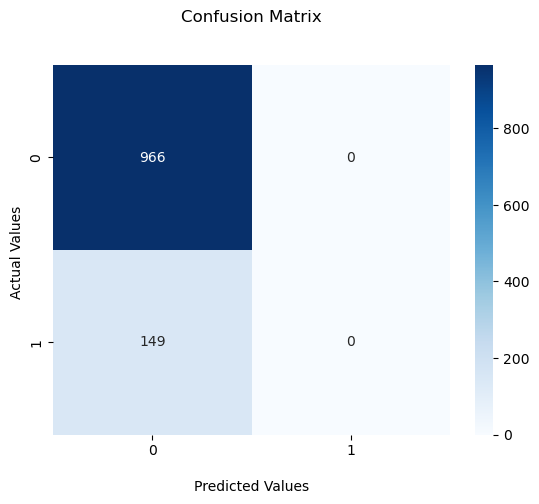

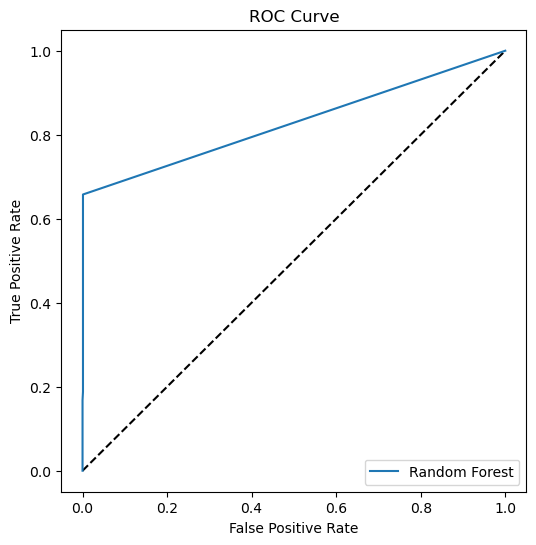

C:\Users\kulin\AppData\Local\Temp\ipykernel_11904\1859841585.py:41: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  metrics_dataframe = metrics_dataframe.append({'Model': name, 'F1_score': f1_metric, 'AUC': auc_metric},


,Model,F1_score,AUC
0,Random Forest,0.0,0.828185


In [7]:
clf1 = RandomForestClassifier(max_depth=2, n_estimators=1000, n_jobs=-1, random_state = 0)
clf1.fit(X_train, y_train)

calculate_metrics(clf1, 'Random Forest', X_test, y_test)

In [8]:
# "Na podstawie tego wykonaj selekcję cech i weź jedynie te, których ważność jest większa niż 0.001."

importances = clf1.feature_importances_
features_names = tfidf.get_feature_names_out()

features = pd.DataFrame({'names':features_names,'importances':importances})
importances_greater_than_0001 = features[features['importances'] > 0.001]
importances_greater_than_0001

,names,importances
4,1000 cash,0.050048
11,1st week,0.007164
13,2000 prize,0.008330
14,2003 account,0.003077
17,2nd attempt,0.007974
...,...,...
404,urgent trying,0.008646
406,valid 12hrs,0.017179
416,want new,0.004410
420,week txt,0.008313


## Sposób 2) clf1 po GridSearchCV

In [9]:
rf = RandomForestClassifier(n_estimators=1000, n_jobs=-1, random_state = 0)
params_rf = {'max_depth': [3, 5, 10, 20],
             'min_samples_leaf': [3, 5, 10, 15]}
rf_gridsearch = GridSearchCV(rf,
                             params_rf,
                             scoring='f1_macro',
                             cv=5,
                             verbose=10, n_jobs=-1)
rf_gridsearch.fit(X_train, y_train)
print('\nBest hyperparameter:', rf_gridsearch.best_params_)
clf2 = rf_gridsearch.best_estimator_

Fitting 5 folds for each of 16 candidates, totalling 80 fits

Best hyperparameter: {'max_depth': 20, 'min_samples_leaf': 3}


              precision    recall  f1-score   support

           0       0.91      1.00      0.95       966
           1       1.00      0.33      0.49       149

    accuracy                           0.91      1115
   macro avg       0.95      0.66      0.72      1115
weighted avg       0.92      0.91      0.89      1115



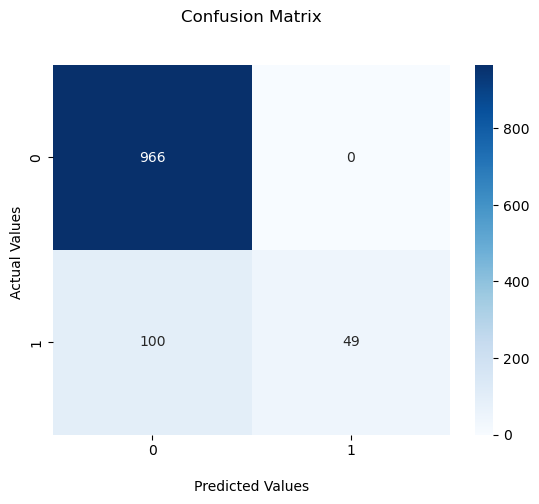

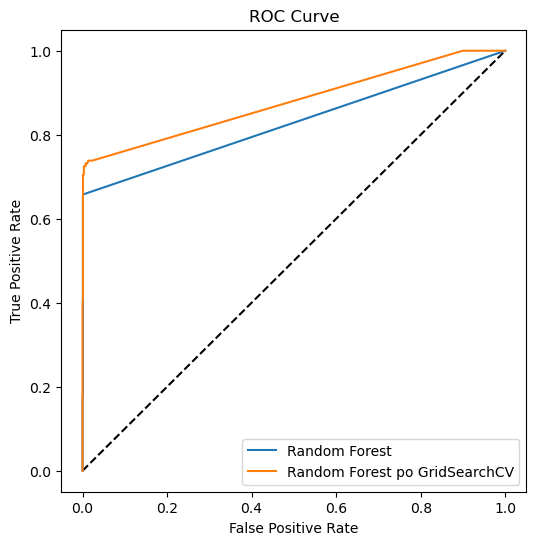

C:\Users\kulin\AppData\Local\Temp\ipykernel_11904\1859841585.py:41: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  metrics_dataframe = metrics_dataframe.append({'Model': name, 'F1_score': f1_metric, 'AUC': auc_metric},


,Model,F1_score,AUC
0,Random Forest,0.000000,0.828185
1,Random Forest po GridSearchCV,0.494949,0.878785


In [10]:
calculate_metrics(clf2, 'Random Forest po GridSearchCV', X_test, y_test)

## Sposób 3) clf1 w pipeline

In [11]:
X = spam_dataset['Text']
y = spam_dataset['Spam']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=43, stratify=y)

In [12]:
class LemmaTokenizer(object):
    def __init__(self):
        self.wnl = WordNetLemmatizer()
    def __call__(self, articles):
        return [self.wnl.lemmatize(t) for t in word_tokenize(articles)]


from sklearn.pipeline import Pipeline
pipeline = Pipeline([
    ('tfidf2', TfidfVectorizer(tokenizer=LemmaTokenizer(),
                              ngram_range=(2, 2),
                              use_idf=True,
                              stop_words='english',
                              lowercase=True)),
    ('clf2', RandomForestClassifier(n_estimators=1000, n_jobs=-1)),
])
parameters = {
    'tfidf2__min_df': [0.001, 0.002, 0.003],
    'tfidf2__max_df': [0.3, 0.4, 0.5],
    'clf2__max_depth': [3, 5, 10, 20],
    'clf2__min_samples_leaf': [3, 5, 10, 15]
}

gs = GridSearchCV(pipeline,
                  parameters)
gs.fit(X_train, y_train)

print('\nBest hyperparameter:', gs.best_params_)
clf3 = gs.best_estimator_

C:\Users\kulin\anaconda3\lib\site-packages\sklearn\feature_extraction\text.py:396: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['ha', 'le', 'u', 'wa'] not in stop_words.
  warnings.warn(
C:\Users\kulin\anaconda3\lib\site-packages\sklearn\feature_extraction\text.py:396: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['ha', 'le', 'u', 'wa'] not in stop_words.
  warnings.warn(
C:\Users\kulin\anaconda3\lib\site-packages\sklearn\feature_extraction\text.py:396: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['ha', 'le', 'u', 'wa'] not in stop_words.
  warnings.warn(
C:\Users\kulin\anaconda3\lib\site-packages\sklearn\feature_extraction\text.py:396: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['ha', 'le', 'u', 'w

C:\Users\kulin\anaconda3\lib\site-packages\sklearn\feature_extraction\text.py:396: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['ha', 'le', 'u', 'wa'] not in stop_words.
  warnings.warn(
C:\Users\kulin\anaconda3\lib\site-packages\sklearn\feature_extraction\text.py:396: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['ha', 'le', 'u', 'wa'] not in stop_words.
  warnings.warn(
C:\Users\kulin\anaconda3\lib\site-packages\sklearn\feature_extraction\text.py:396: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['ha', 'le', 'u', 'wa'] not in stop_words.
  warnings.warn(
C:\Users\kulin\anaconda3\lib\site-packages\sklearn\feature_extraction\text.py:396: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['ha', 'le', 'u', 'w

C:\Users\kulin\anaconda3\lib\site-packages\sklearn\feature_extraction\text.py:396: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['ha', 'le', 'u', 'wa'] not in stop_words.
  warnings.warn(
C:\Users\kulin\anaconda3\lib\site-packages\sklearn\feature_extraction\text.py:396: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['ha', 'le', 'u', 'wa'] not in stop_words.
  warnings.warn(
C:\Users\kulin\anaconda3\lib\site-packages\sklearn\feature_extraction\text.py:396: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['ha', 'le', 'u', 'wa'] not in stop_words.
  warnings.warn(
C:\Users\kulin\anaconda3\lib\site-packages\sklearn\feature_extraction\text.py:396: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['ha', 'le', 'u', 'w

C:\Users\kulin\anaconda3\lib\site-packages\sklearn\feature_extraction\text.py:396: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['ha', 'le', 'u', 'wa'] not in stop_words.
  warnings.warn(
C:\Users\kulin\anaconda3\lib\site-packages\sklearn\feature_extraction\text.py:396: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['ha', 'le', 'u', 'wa'] not in stop_words.
  warnings.warn(
C:\Users\kulin\anaconda3\lib\site-packages\sklearn\feature_extraction\text.py:396: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['ha', 'le', 'u', 'wa'] not in stop_words.
  warnings.warn(
C:\Users\kulin\anaconda3\lib\site-packages\sklearn\feature_extraction\text.py:396: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['ha', 'le', 'u', 'w

C:\Users\kulin\anaconda3\lib\site-packages\sklearn\feature_extraction\text.py:396: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['ha', 'le', 'u', 'wa'] not in stop_words.
  warnings.warn(
C:\Users\kulin\anaconda3\lib\site-packages\sklearn\feature_extraction\text.py:396: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['ha', 'le', 'u', 'wa'] not in stop_words.
  warnings.warn(
C:\Users\kulin\anaconda3\lib\site-packages\sklearn\feature_extraction\text.py:396: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['ha', 'le', 'u', 'wa'] not in stop_words.
  warnings.warn(
C:\Users\kulin\anaconda3\lib\site-packages\sklearn\feature_extraction\text.py:396: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['ha', 'le', 'u', 'w

C:\Users\kulin\anaconda3\lib\site-packages\sklearn\feature_extraction\text.py:396: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['ha', 'le', 'u', 'wa'] not in stop_words.
  warnings.warn(
C:\Users\kulin\anaconda3\lib\site-packages\sklearn\feature_extraction\text.py:396: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['ha', 'le', 'u', 'wa'] not in stop_words.
  warnings.warn(
C:\Users\kulin\anaconda3\lib\site-packages\sklearn\feature_extraction\text.py:396: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['ha', 'le', 'u', 'wa'] not in stop_words.
  warnings.warn(
C:\Users\kulin\anaconda3\lib\site-packages\sklearn\feature_extraction\text.py:396: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['ha', 'le', 'u', 'w

C:\Users\kulin\anaconda3\lib\site-packages\sklearn\feature_extraction\text.py:396: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['ha', 'le', 'u', 'wa'] not in stop_words.
  warnings.warn(
C:\Users\kulin\anaconda3\lib\site-packages\sklearn\feature_extraction\text.py:396: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['ha', 'le', 'u', 'wa'] not in stop_words.
  warnings.warn(
C:\Users\kulin\anaconda3\lib\site-packages\sklearn\feature_extraction\text.py:396: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['ha', 'le', 'u', 'wa'] not in stop_words.
  warnings.warn(
C:\Users\kulin\anaconda3\lib\site-packages\sklearn\feature_extraction\text.py:396: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['ha', 'le', 'u', 'w

C:\Users\kulin\anaconda3\lib\site-packages\sklearn\feature_extraction\text.py:396: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['ha', 'le', 'u', 'wa'] not in stop_words.
  warnings.warn(
C:\Users\kulin\anaconda3\lib\site-packages\sklearn\feature_extraction\text.py:396: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['ha', 'le', 'u', 'wa'] not in stop_words.
  warnings.warn(
C:\Users\kulin\anaconda3\lib\site-packages\sklearn\feature_extraction\text.py:396: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['ha', 'le', 'u', 'wa'] not in stop_words.
  warnings.warn(
C:\Users\kulin\anaconda3\lib\site-packages\sklearn\feature_extraction\text.py:396: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['ha', 'le', 'u', 'w

C:\Users\kulin\anaconda3\lib\site-packages\sklearn\feature_extraction\text.py:396: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['ha', 'le', 'u', 'wa'] not in stop_words.
  warnings.warn(
C:\Users\kulin\anaconda3\lib\site-packages\sklearn\feature_extraction\text.py:396: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['ha', 'le', 'u', 'wa'] not in stop_words.
  warnings.warn(
C:\Users\kulin\anaconda3\lib\site-packages\sklearn\feature_extraction\text.py:396: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['ha', 'le', 'u', 'wa'] not in stop_words.
  warnings.warn(
C:\Users\kulin\anaconda3\lib\site-packages\sklearn\feature_extraction\text.py:396: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['ha', 'le', 'u', 'w

C:\Users\kulin\anaconda3\lib\site-packages\sklearn\feature_extraction\text.py:396: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['ha', 'le', 'u', 'wa'] not in stop_words.
  warnings.warn(
C:\Users\kulin\anaconda3\lib\site-packages\sklearn\feature_extraction\text.py:396: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['ha', 'le', 'u', 'wa'] not in stop_words.
  warnings.warn(
C:\Users\kulin\anaconda3\lib\site-packages\sklearn\feature_extraction\text.py:396: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['ha', 'le', 'u', 'wa'] not in stop_words.
  warnings.warn(
C:\Users\kulin\anaconda3\lib\site-packages\sklearn\feature_extraction\text.py:396: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['ha', 'le', 'u', 'w

C:\Users\kulin\anaconda3\lib\site-packages\sklearn\feature_extraction\text.py:396: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['ha', 'le', 'u', 'wa'] not in stop_words.
  warnings.warn(
C:\Users\kulin\anaconda3\lib\site-packages\sklearn\feature_extraction\text.py:396: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['ha', 'le', 'u', 'wa'] not in stop_words.
  warnings.warn(
C:\Users\kulin\anaconda3\lib\site-packages\sklearn\feature_extraction\text.py:396: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['ha', 'le', 'u', 'wa'] not in stop_words.
  warnings.warn(
C:\Users\kulin\anaconda3\lib\site-packages\sklearn\feature_extraction\text.py:396: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['ha', 'le', 'u', 'w

C:\Users\kulin\anaconda3\lib\site-packages\sklearn\feature_extraction\text.py:396: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['ha', 'le', 'u', 'wa'] not in stop_words.
  warnings.warn(
C:\Users\kulin\anaconda3\lib\site-packages\sklearn\feature_extraction\text.py:396: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['ha', 'le', 'u', 'wa'] not in stop_words.
  warnings.warn(
C:\Users\kulin\anaconda3\lib\site-packages\sklearn\feature_extraction\text.py:396: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['ha', 'le', 'u', 'wa'] not in stop_words.
  warnings.warn(
C:\Users\kulin\anaconda3\lib\site-packages\sklearn\feature_extraction\text.py:396: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['ha', 'le', 'u', 'w

C:\Users\kulin\anaconda3\lib\site-packages\sklearn\feature_extraction\text.py:396: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['ha', 'le', 'u', 'wa'] not in stop_words.
  warnings.warn(
C:\Users\kulin\anaconda3\lib\site-packages\sklearn\feature_extraction\text.py:396: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['ha', 'le', 'u', 'wa'] not in stop_words.
  warnings.warn(
C:\Users\kulin\anaconda3\lib\site-packages\sklearn\feature_extraction\text.py:396: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['ha', 'le', 'u', 'wa'] not in stop_words.
  warnings.warn(
C:\Users\kulin\anaconda3\lib\site-packages\sklearn\feature_extraction\text.py:396: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['ha', 'le', 'u', 'w

C:\Users\kulin\anaconda3\lib\site-packages\sklearn\feature_extraction\text.py:396: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['ha', 'le', 'u', 'wa'] not in stop_words.
  warnings.warn(
C:\Users\kulin\anaconda3\lib\site-packages\sklearn\feature_extraction\text.py:396: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['ha', 'le', 'u', 'wa'] not in stop_words.
  warnings.warn(
C:\Users\kulin\anaconda3\lib\site-packages\sklearn\feature_extraction\text.py:396: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['ha', 'le', 'u', 'wa'] not in stop_words.
  warnings.warn(
C:\Users\kulin\anaconda3\lib\site-packages\sklearn\feature_extraction\text.py:396: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['ha', 'le', 'u', 'w

C:\Users\kulin\anaconda3\lib\site-packages\sklearn\feature_extraction\text.py:396: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['ha', 'le', 'u', 'wa'] not in stop_words.
  warnings.warn(
C:\Users\kulin\anaconda3\lib\site-packages\sklearn\feature_extraction\text.py:396: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['ha', 'le', 'u', 'wa'] not in stop_words.
  warnings.warn(
C:\Users\kulin\anaconda3\lib\site-packages\sklearn\feature_extraction\text.py:396: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['ha', 'le', 'u', 'wa'] not in stop_words.
  warnings.warn(
C:\Users\kulin\anaconda3\lib\site-packages\sklearn\feature_extraction\text.py:396: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['ha', 'le', 'u', 'w

C:\Users\kulin\anaconda3\lib\site-packages\sklearn\feature_extraction\text.py:396: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['ha', 'le', 'u', 'wa'] not in stop_words.
  warnings.warn(
C:\Users\kulin\anaconda3\lib\site-packages\sklearn\feature_extraction\text.py:396: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['ha', 'le', 'u', 'wa'] not in stop_words.
  warnings.warn(
C:\Users\kulin\anaconda3\lib\site-packages\sklearn\feature_extraction\text.py:396: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['ha', 'le', 'u', 'wa'] not in stop_words.
  warnings.warn(
C:\Users\kulin\anaconda3\lib\site-packages\sklearn\feature_extraction\text.py:396: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['ha', 'le', 'u', 'w

C:\Users\kulin\anaconda3\lib\site-packages\sklearn\feature_extraction\text.py:396: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['ha', 'le', 'u', 'wa'] not in stop_words.
  warnings.warn(
C:\Users\kulin\anaconda3\lib\site-packages\sklearn\feature_extraction\text.py:396: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['ha', 'le', 'u', 'wa'] not in stop_words.
  warnings.warn(
C:\Users\kulin\anaconda3\lib\site-packages\sklearn\feature_extraction\text.py:396: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['ha', 'le', 'u', 'wa'] not in stop_words.
  warnings.warn(
C:\Users\kulin\anaconda3\lib\site-packages\sklearn\feature_extraction\text.py:396: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['ha', 'le', 'u', 'w

C:\Users\kulin\anaconda3\lib\site-packages\sklearn\feature_extraction\text.py:396: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['ha', 'le', 'u', 'wa'] not in stop_words.
  warnings.warn(
C:\Users\kulin\anaconda3\lib\site-packages\sklearn\feature_extraction\text.py:396: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['ha', 'le', 'u', 'wa'] not in stop_words.
  warnings.warn(
C:\Users\kulin\anaconda3\lib\site-packages\sklearn\feature_extraction\text.py:396: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['ha', 'le', 'u', 'wa'] not in stop_words.
  warnings.warn(
C:\Users\kulin\anaconda3\lib\site-packages\sklearn\feature_extraction\text.py:396: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['ha', 'le', 'u', 'w

C:\Users\kulin\anaconda3\lib\site-packages\sklearn\feature_extraction\text.py:396: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['ha', 'le', 'u', 'wa'] not in stop_words.
  warnings.warn(
C:\Users\kulin\anaconda3\lib\site-packages\sklearn\feature_extraction\text.py:396: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['ha', 'le', 'u', 'wa'] not in stop_words.
  warnings.warn(
C:\Users\kulin\anaconda3\lib\site-packages\sklearn\feature_extraction\text.py:396: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['ha', 'le', 'u', 'wa'] not in stop_words.
  warnings.warn(
C:\Users\kulin\anaconda3\lib\site-packages\sklearn\feature_extraction\text.py:396: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['ha', 'le', 'u', 'w

C:\Users\kulin\anaconda3\lib\site-packages\sklearn\feature_extraction\text.py:396: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['ha', 'le', 'u', 'wa'] not in stop_words.
  warnings.warn(
C:\Users\kulin\anaconda3\lib\site-packages\sklearn\feature_extraction\text.py:396: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['ha', 'le', 'u', 'wa'] not in stop_words.
  warnings.warn(
C:\Users\kulin\anaconda3\lib\site-packages\sklearn\feature_extraction\text.py:396: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['ha', 'le', 'u', 'wa'] not in stop_words.
  warnings.warn(
C:\Users\kulin\anaconda3\lib\site-packages\sklearn\feature_extraction\text.py:396: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['ha', 'le', 'u', 'w

C:\Users\kulin\anaconda3\lib\site-packages\sklearn\feature_extraction\text.py:396: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['ha', 'le', 'u', 'wa'] not in stop_words.
  warnings.warn(
C:\Users\kulin\anaconda3\lib\site-packages\sklearn\feature_extraction\text.py:396: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['ha', 'le', 'u', 'wa'] not in stop_words.
  warnings.warn(
C:\Users\kulin\anaconda3\lib\site-packages\sklearn\feature_extraction\text.py:396: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['ha', 'le', 'u', 'wa'] not in stop_words.
  warnings.warn(
C:\Users\kulin\anaconda3\lib\site-packages\sklearn\feature_extraction\text.py:396: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['ha', 'le', 'u', 'w

C:\Users\kulin\anaconda3\lib\site-packages\sklearn\feature_extraction\text.py:396: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['ha', 'le', 'u', 'wa'] not in stop_words.
  warnings.warn(
C:\Users\kulin\anaconda3\lib\site-packages\sklearn\feature_extraction\text.py:396: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['ha', 'le', 'u', 'wa'] not in stop_words.
  warnings.warn(
C:\Users\kulin\anaconda3\lib\site-packages\sklearn\feature_extraction\text.py:396: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['ha', 'le', 'u', 'wa'] not in stop_words.
  warnings.warn(
C:\Users\kulin\anaconda3\lib\site-packages\sklearn\feature_extraction\text.py:396: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['ha', 'le', 'u', 'w

C:\Users\kulin\anaconda3\lib\site-packages\sklearn\feature_extraction\text.py:396: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['ha', 'le', 'u', 'wa'] not in stop_words.
  warnings.warn(
C:\Users\kulin\anaconda3\lib\site-packages\sklearn\feature_extraction\text.py:396: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['ha', 'le', 'u', 'wa'] not in stop_words.
  warnings.warn(
C:\Users\kulin\anaconda3\lib\site-packages\sklearn\feature_extraction\text.py:396: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['ha', 'le', 'u', 'wa'] not in stop_words.
  warnings.warn(
C:\Users\kulin\anaconda3\lib\site-packages\sklearn\feature_extraction\text.py:396: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['ha', 'le', 'u', 'w


Best hyperparameter: {'clf2__max_depth': 20, 'clf2__min_samples_leaf': 3, 'tfidf2__max_df': 0.4, 'tfidf2__min_df': 0.003}


              precision    recall  f1-score   support

           0       0.91      1.00      0.95       966
           1       1.00      0.36      0.53       149

    accuracy                           0.91      1115
   macro avg       0.96      0.68      0.74      1115
weighted avg       0.92      0.91      0.90      1115



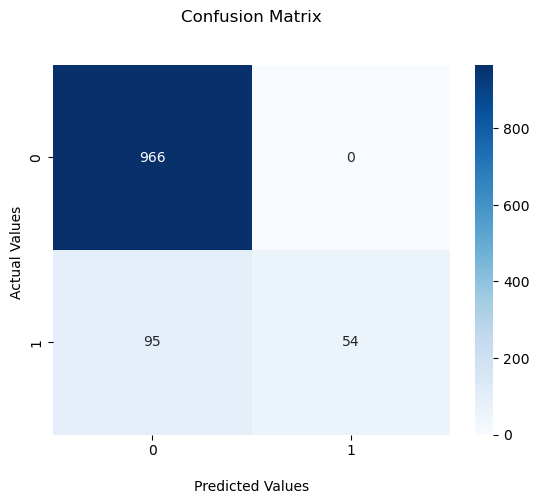

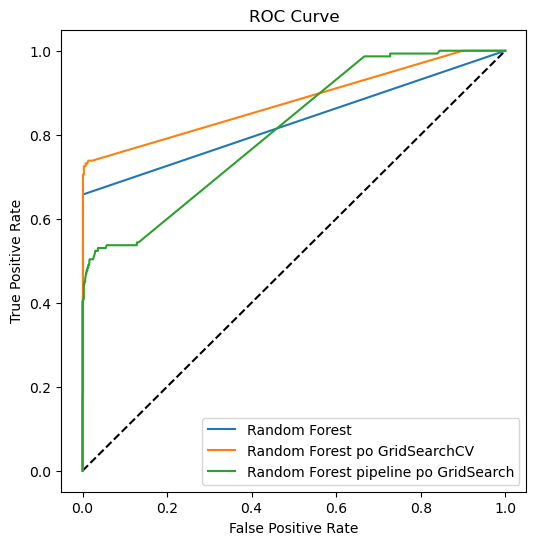

C:\Users\kulin\AppData\Local\Temp\ipykernel_11904\1859841585.py:41: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  metrics_dataframe = metrics_dataframe.append({'Model': name, 'F1_score': f1_metric, 'AUC': auc_metric},


,Model,F1_score,AUC
0,Random Forest,0.000000,0.828185
1,Random Forest po GridSearchCV,0.494949,0.878785
2,Random Forest pipeline po GridSearch,0.532020,0.809701


In [13]:
calculate_metrics(clf3, 'Random Forest pipeline po GridSearch', X_test, y_test)

# Wnioski:

Model clf1 jest zupełnie bezużyteczny. Zakwalifikował wszystko jako nie-spam.

Model clf2 jest lepszy. Nie pomylił się w ocenie nie-spamu (każdą wiadomośc zaklasyfikował jako wiadomość), natomiast jako spam zaliczył 49 ze 149.

Model clf3 jest z tych trzech najlepszy, ponieważ dobrał optymalne parametry TfidfVectorizer'a. Wszystkie wiadomości zakwalifikowane prawidłowo, spam dobrze zakwalifikowany w 54 przypadkach na 149.